# Ensembles
This notebook is setup to run ensemble simulations

Stipulations for ensembles:
- no seasonality
- run monthly
- Aquaseca's notebook was our base model

Parameter Values
- 1. K1, K2, and K3 = [5, 25, 100] # baseline Kx=Ky=Kz value in all zones (m/day)
- 2. Kz ratio_lowK = [1e-6, 1e-2, 1] # ratio of Kz in low-K layer to baseline K (-)
- 3. Sy = [0.05, 0.1, 0.3] # specific yield (-)
- 4. R_mountains = [1e-5, 3e-5, 5e-5] # recharge rate in mountains (m/day)
- 5. ET_valley = [1e-6, 1e-5, 1e-4] # ET rate in valley (m/day)
- 6. ETratio_riparian = [1, 2, 3] # ratio of ET in riparian area to ET rate in valley (m/day)
- 7. Kratio_streambed = [1e-2,1e-1, 1] # ratio of K in streambed to baseline K (-)


# 1. Packages

In [188]:
#import packages
import flopy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import pandas as pd
import numpy as np
import os
import csv

#additional analysis tools
import flopy.utils.binaryfile as bf
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
np.set_printoptions(threshold=np.inf)

#jupyter specific--included to show plots in notebook
%matplotlib inline 

# 2. Discretization and other inputs

In [189]:
# Discretization
nrow = 50 #number of rows
ncol = 50 #number of columns
nlay = 3  #number of layers

dx= 1000 #width of grid cells in x direction 
dy= 1000 #width of grid cells in y direction 
Lx = ncol*dx  #width of domain in x
Ly = nrow*dy #width of domain in y

with open('BASE_top_elev.csv', 'r', encoding='utf-8-sig') as reader: 
    ztop = np.genfromtxt(reader, dtype=float, delimiter=',') # elevation of top layer (import from csv file) (dim: nrow,ncol)

## set the bottom elevations of every layer
botm = np.zeros((nlay, nrow, ncol))
botm[2, :, :] = 0
botm[1, :, :] = 40              # bottom elevation of middle layer (1) is 40 m
botm[0, :, :] = 45              # bottom elevation of top layer (0) 45

# Boundary conditions
h_right = 70  #right side constant head 70m

## Subsurface properties
n = 0.1        #assign porosity
Ss = 0.0001      #assign storage coefficient
uncnf = 1       #0=confined, >0 = unconfined

#supply well
pumping = 0 #m3/day 
well_row = 21
well_col = 38
well_loc = (0,well_row, well_col)
well = [2,well_row, well_col, pumping] #Well loc shoudl be layer, row, column
print("Town well location(layer, col, row)", well_row, well_col)

#irrigation well
pumping_irr = -4500 #m3/day 
welli_row = 12 
welli_col = 14 
welli_loc = (0,welli_row, welli_col)
welli = [0,welli_row, welli_col, pumping_irr] 
print("Irrigation well location(layer, col, row)", welli_row, welli_col)

# Agricultural recharge rate
agrech = 0.00015  # pistachios (1/8th area already included)

# ET extinction depth
extinction_depth = 10  # m


Town well location(layer, col, row) 21 38
Irrigation well location(layer, col, row) 12 14


 ## Name of run and Parameter Inputs

In [190]:
ensembles = [[3,3,3,3,3,3,3],
[3,3,1,3,3,3,3], 
[3,3,3,1,3,3,3],
[3,3,3,3,3,3,1],
[2,2,3,3,2,2,3],
[2,2,1,3,2,2,3],
[2,2,3,1,2,2,3],
[2,2,3,3,2,2,1],
[2,2,1,1,2,2,1],
[1,1,1,1,1,1,1]]

i = 0 #picking one ensemble member

name = "ensemble_"
for p in range(7):
    string = str(ensemble_num[p])
    name = name + string


print(name)

#Ensemble Variables -- in the order they are listed
k_list = [5,25,100]
kratio_list  = [1e-6,1e-2, 1]
sy_list = [0.05, 0.1, 0.3]
rmountain_list = [1e-5, 3e-5, 5e-5]
etvalley_list = [1e-6, 1e-5, 1e-4]
etratio_list = [1,2,3]
streamk_list = [1e-2, 1e-1,1]

#Select variables given ensemble number i
print(i)
K_horiz = k_list[(ensembles[i][0]-1)]
K_vert = k_list[(ensembles[i][0]-1)]
K_horiz2 = K_horiz * kratio_list[(ensembles[i][1]-1)]
K_vert2 = K_vert * kratio_list[(ensembles[i][1]-1)]
Sy= sy_list[(ensembles[i][2]-1)]
rech = rmountain_list[(ensembles[i][3]-1)]
ET = etvalley_list[(ensembles[i][4]-1)]
rip_ET = ET * etratio_list[(ensembles[i][5]-1)]


print('K Upper and Lower:', K_horiz, "Middle K:", K_vert2)
print('Specific Yield:', Sy, "Mountain Recharge:", rech)
print('Valley ET:', ET, "Riparian ET:", rip_ET)


ensemble_3313333
0
K Upper and Lower: 100 Middle K: 100
Specific Yield: 0.3 Mountain Recharge: 5e-05
Valley ET: 0.0001 Riparian ET: 0.00030000000000000003


## 2.1 Parameters that change

### Recharge

In [191]:
nper = 301
rech_zone_forced = np.zeros((1, nrow,ncol))
rech_zone_forced[0, :, 0:15] = rech
rech_zone_with_ag = np.zeros((1, nrow,ncol))
rech_zone_with_ag[0, 20:22, 18:20] = agrech


rech_dict = {}
for i in range(nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
    if i <= 199:
        rech_dict[i] = rech_zone_forced
        #print(i)
    elif i > 199:  
        #print(i)
        rech_dict[i] = rech_zone_with_ag

### K values

In [192]:
## make horizontal K np arrays
Kh = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kh[:,:,:] = K_horiz # assign the original value to the entire array

## Make a arrays for the K values
Kz = np.zeros((nlay,nrow,ncol))     # define an array of zeros the size of the model grid (nlay, nrow, ncol)
Kz[:,:,:] = K_vert                   # assign the original value to the entire array
Kz[1,:,20:49] = K_vert2            #Replace K in the middle layer with the lower value
#Kz[1,:,:] = K_vert2

print(K_horiz,K_vert, K_horiz2, K_vert2)

100 100 100 100


### Stream K

In [193]:
riv_row= 24
riv_sp = [] #create list to store all river cells for stress period 1


#Kratio_streambed = [1e-2,1e-1, 1] # ratio of K in streambed to baseline K (-)
if ensemble_num[6] == 1:
    k_rivbott = K_vert*0.01
elif ensemble_num[6] == 2:
    k_rivbott = K_vert*0.1
else:
    k_rivbott = K_vert*1


# k_rivbott1 = 0.01 #river bottom hydraulic conductivity in m/d
# k_rivbott3 = 1 #river bottom hydraulic conductivity in m/d
# # Kratio_streambed = [1e-2,1e-1, 1]

sed_thick = 1 #thickness of riverbed sediment in m
cond = k_rivbott*(1)*(1000)/(sed_thick) #river bed conductance in m^2/d
r_stage = .5 #stage in river (stress period 1)
r_bott = ztop[riv_row,:] #river bottom
#print(r_bott)
for i in range(1,ncol):
    riv_sp.append([0, riv_row, i, r_bott[i]-1+sed_thick+r_stage, cond, r_bott[i]-2])
    
#print(riv_spd)
#create dictionary of stress period data
riv_spd = {0: riv_sp}
#print(riv_spd)

## 2.2 Stressperiods

In [194]:
sp_peryr = 1   #number of seasons (with and wihtout ET. April-Sept and Oct-Mar)
sp_len = 360  #sp lengths
sim_years = 20
nper = int(sp_peryr*sim_years)+1
#nper = 1
#setup the steady state array
steady = np.ones(nper, dtype=bool)*False     # steady-state or transient flag for each stress period (boolean array)
#print(steady)
steady[0] = True    # initial stress period is steady-state

#make an array of period lengths
perlen=np.tile([sp_len],sim_years+1)
#perlen=np.append(10,perlen) #add a period of length 10 at the start for the steady state simulation
print("Period lengths", perlen)

#make an nstp array for the # of time steps to solve within each period in this case we will do daily 

nstp=perlen/30 #30 for monthly
#nstp[0]=1 #for the steady state solution we just want one output
nstp = nstp.astype(int)
#print("Number of Steps", nstp)




Period lengths [360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360 360
 360 360 360]


### Pumping and burnin

In [195]:
wel_spd = {}    
    
burn = 100 #0 because of the head file read in
decade = 1
#decade2 = 10 #to calculate pumping after 100 year pumping
pump = 47
pumpingag4 = -4500
#total pumping = 
for strper in range(0, nper):    
    if strper < burn:
        pumping = 0
        wel_spd[strper] = [[2,well_row, well_col, pumping], [0, welli_row, welli_col, 0]]
    elif strper < (burn + 100):
        if strper < (burn+decade*10):
            pumping = round(pump * (decade**1.5)) *-1
            wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, welli_row, welli_col, 0]]
        else:
            decade = decade + 1   
            pumping = round(pump * (decade**1.5)) *-1
            wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, welli_row, welli_col, 0]]
    else:
        if strper < (burn+decade*10):
            pumping = round(pump * (decade**1.5)) *-1
            wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, welli_row, welli_col, pumpingag4]]
        else:
            decade = decade + 1   
            pumping = round(pump * (decade**1.5)) *-1
            wel_spd[strper] =  [[2,well_row, well_col, pumping], [0, welli_row, welli_col, pumpingag4]]
    
#print(wel_spd)
#print(wel_spd)

### ET

In [196]:
## ET


ET_zone = np.zeros((1,nrow,ncol))     # define an array of zeroes the size of the model grid
ET_zone[0,:, 25:] = ET 
ET_zone[0, 21:28, :] = rip_ET


ET_dict = {} #set up an ET dictionary, where each key is a stress period num 0-50

for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
    ET_dict[p] = ET_zone
    #print(ET_dict)
# for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
#     if p == 0:
#         ET_dict[p] = ET_zone
#     elif p % 2) != 0:
#         ET_dict[p]=ET_zone2
#         #print(p)
#     else: 
#         ET_dict[p] = ET_zone

# #No steady state test
# for p in range(0,nper):    #loop over stress periods, odds are 0 ET, evens are reg ET
#     if p == 0:
#         ET_dict[p] = ET_zone2
#     elif int(p % 2) != 0:
#         ET_dict[p]=ET_zone
#         #print(p)
#     else: 
#         ET_dict[p] = ET_zone2


## 2.3 Ibounds

In [197]:
#read in burn-in head values
print(os.getcwd())
# H_init = np.ones((nlay, nrow, ncol), dtype=np.float32) 
# H_init[0,:,:] = np.loadtxt('postdev_toplayer_h_init.csv', delimiter=",")
# H_init[1,:,:] = np.loadtxt('postdev_midlayer_h_init.csv', delimiter=",")
# H_init[2,:,:] = np.loadtxt('postdev_botlayer_h_init.csv', delimiter=",")
# print(H_init[2,:,1])

H_init = np.ones((nlay, nrow, ncol), dtype=np.float32)  #float array (i.e. decimal), sets all heads to 1.0
H_init[:, :, :] = h_right  #initialize the entire domain to the right head value
H_init[:, :, 49] = h_right    #replace first (right) col with desired head value

#Define cell activity (IBOUND)
ibound=np.ones((nlay,nrow,ncol))                                                  
ibound[:,:,0] = 0  #1st col = no flow       
ibound[:,:,49] = -1  #last col = constant head 

ibound[:,0,:49]=0
ibound[:,49,:49]=0
ibound[:,1,:5]=0
ibound[:,2,:4]=0
ibound[:,3,:3]=0
ibound[:,4,:2]=0

ibound[:,48,:5]=0
ibound[:,47,:4]=0
ibound[:,46,:3]=0
ibound[:,45,:2]=0

ibound[1:,1,:7]=0
ibound[1:,2,:6]=0
ibound[1:,3,:5]=0
ibound[1:,4,:4]=0
ibound[1:,5,:3]=0
ibound[1:,6,1]=0

ibound[1:,48,:7]=0
ibound[1:,47,:6]=0
ibound[1:,46,:5]=0
ibound[1:,45,:4]=0
ibound[1:,44,:3]=0
ibound[1:,43,1]=0

ibound[2,1,:9]=0
ibound[2,2,:8]=0
ibound[2,3,:7]=0
ibound[2,4,:6]=0
ibound[2,5,:5]=0
ibound[2,6,:4]=0
ibound[2,7,:3]=0
ibound[2,8,1]=0

ibound[2,48,:9]=0
ibound[2,47,:8]=0
ibound[2,46,:7]=0
ibound[2,45,:6]=0
ibound[2,44,:5]=0
ibound[2,43,:4]=0
ibound[2,42,:3]=0
ibound[2,41,1]=0

/Users/laura/Documents/Teaching/Groundwater_Modeling/HWRS582_Spring22/Course-Materials22/Assignments/HW14_FinalProject


# 3. Run Modflow

In [198]:
#create model object
modelname = "Ensembles"
modelname = name
moddir="/Applications/MODFLOW/mf2005"
#moddir = "/Users/abramfarley/Desktop/gw_modeling/ModFlow_Builds/pymake/examples/mf2005"
#moddir="C:/WRDAPP/MF2005.1_12/bin/mf2005.exe"
m = flopy.modflow.Modflow(modelname, exe_name = moddir)


#Discretization - dis
# dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
#                                delr=dx, delc=dy, top=ztop, botm=botm, 
#                                itmuni = 4, lenuni = 2, 
#                                nper=1, steady=[True])
dis = flopy.modflow.ModflowDis(model=m, nlay=nlay, nrow=nrow, ncol=ncol, 
                               delr=dx, delc=dy, top=ztop, botm=botm, 
                               itmuni = 4, lenuni = 2, 
                               nper=nper, steady=steady, perlen=perlen, nstp=nstp)

# Boundary and initial conditions - bas
bas = flopy.modflow.ModflowBas(m, ibound=ibound, strt=H_init)

#Layer properties - lpf
lpf = flopy.modflow.ModflowLpf(m, laytyp=1, hk=Kh, 
                               vka=Kz, ss=Ss,
                               sy=Sy,storagecoefficient=True, ipakcb=53)
#ET - evt
evt = flopy.modflow.mfevt.ModflowEvt(m, surf=ztop, evtr=ET_dict, exdp=extinction_depth, ipakcb=53) 

#Recharge - rch
rch = flopy.modflow.mfrch.ModflowRch(model=m, rech=rech_dict, ipakcb=53)     #create rch object

#River - riv
riv = flopy.modflow.ModflowRiv(model=m, stress_period_data = riv_spd, ipakcb=53)

#Well - wel
wel = flopy.modflow.ModflowWel(model=m, stress_period_data=wel_spd)

# #Storage?
# sto = flopy.mf6.modflow.mfgwfsto.ModflowGwfsto(model=m, loading_package=False, save_flows=True, storagecoefficient=None, iconvert=0, ss=Ss, sy=Sy, transient=True)

#Output control - OC 
#spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...'] 

oc_spd = {}
for kper in range(0, nper):
    for kstp in range(nstp[kper]):
        #print(kstp)
        oc_spd[(kper, kstp)] = ['save head','save drawdown','save budget','print head','print budget']
# #print(np.shape(oc_spd))
#spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']}

oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

# oc_spd = {}
# for kper in range(0,nper-1): #nper is 201, this is the key for each entry in oc_spd dict
#     oc_spd[(kper, 1)] = ['save head','save drawdown','save budget','print head','print budget']
#     oc_spd[(kper, 90)] = ['save head','save drawdown','save budget','print head','print budget']
#     oc_spd[(kper, 179)] = ['save head','save drawdown','save budget','print head','print budget']
# oc = flopy.modflow.ModflowOc(model=m, stress_period_data=oc_spd, compact=True)

#Numerical solver - pcg
pcg = flopy.modflow.ModflowPcg(model=m, mxiter=5000, iter1=500, relax = 0.97, damp = 0.01)

#write the inputs
m.write_input()   

#check stuff
#m.evt.check()
m.oc.check()
m.oc.check()
m.lpf.check()
#m.pcg.check()
m.riv.check()
m.rch.check()
m.dis.check()



#Run the model 
success, mfoutput = m.run_model(pause=False, report=True)
if not success:
    raise Exception('MODFLOW did not terminate normally.')


OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


OC PACKAGE DATA VALIDATION:
  No errors or warnings encountered.


LPF PACKAGE DATA VALIDATION:
  1 Warning:
    STORAGECOEFFICIENT option is activated, storage values are read storage coefficients

  Checks that passed:
    zero or negative horizontal hydraulic conductivity values
    zero or negative vertical hydraulic conductivity values
    negative horizontal anisotropy values
    horizontal hydraulic conductivity values below checker threshold of 1e-11
    horizontal hydraulic conductivity values above checker threshold of 100000.0
    vertical hydraulic conductivity values below checker threshold of 1e-11
    vertical hydraulic conductivity values above checker threshold of 100000.0
    zero or negative specific storage values
    specific storage values below checker threshold of 1e-06
    specific storage values above checker threshold of 0.01
    zero or negative specific yield values
    specific yield value

# 4. Plotting

### Domain grid

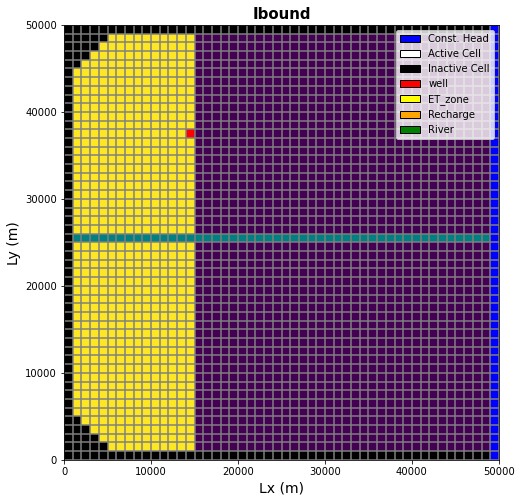

In [199]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, aspect='equal')

modelmap = flopy.plot.PlotMapView(model=m)
grid = modelmap.plot_grid()
#zones = ET_zone + rech_zone_forced
quadmesh = modelmap.plot_array(rech_zone_forced)
#quadmesh = modelmap.plot_array(rech_zone_forced)

riv_plot = modelmap.plot_bc(ftype='RIV')
quadmesh = modelmap.plot_ibound(ibound[0])
wel = modelmap.plot_bc(ftype='WEL')
#quadmesh = modelmap.plot_array(rech_zone_forced) #, color='purple')
#riv_plot = modelmap.plot_bc(ftype='RIV')
#chd_plot = modelmap.plot_bc(ftype='CHD')
#quadmesh = modelmap.plot_bc('WEL')
quadmesh = modelmap.plot_ibound()



#add labels and legend
plt.xlabel('Lx (m)',fontsize = 14)
plt.ylabel('Ly (m)',fontsize = 14)
plt.title('Ibound', fontsize = 15, fontweight = 'bold')
plt.legend(handles=[mp.patches.Patch(color='blue',label='Const. Head',ec='black'),
                   mp.patches.Patch(color='white',label='Active Cell',ec='black'),
                   mp.patches.Patch(color='black',label='Inactive Cell',ec='black'),
                    mp.patches.Patch(color='red',label='well',ec='black'), 
                   mp.patches.Patch(color='yellow',label='ET_zone',ec='black'),
                    mp.patches.Patch(color='orange',label='Recharge',ec='black'),
                    mp.patches.Patch(color='green',label='River',ec='black')
                   ])

plt.show(modelmap)
#plt.savefig('Domaingrid.png')

### Read in binary files

In [200]:
#hds = bf.HeadFile(modelname+'.hds')                   # reads the binary head file
#times = hds.get_times() # returns a list of timesteps
#times = []
# for t in range(len(perlen)):
#     if t == 0:
#         times.append(perlen[t])
#     else:
#         times.append(times[t-1]+perlen[t])
#print(times)

#head = hds.get_alldata() 
#print(head)
head = {}
leakage = {}
fff = {}
stor = {}
recharge = {}
et = {}
frf = {}
headobj = flopy.utils.binaryfile.HeadFile(modelname+'.hds')
budgobj = flopy.utils.binaryfile.CellBudgetFile(modelname+'.cbc')
times = headobj.get_times()
#print(budgobj.get_unique_record_names())

for stress_per, time in enumerate(times): #iterate through times at end of each stress period
    head['sp%s'%(stress_per)] = headobj.get_data(totim=time) #append heads to head list for ea stress per
    leakage['sp%s'%(stress_per)] = budgobj.get_data(text='RIVER LEAKAGE',totim=time) #append right face flow to frf list for ea stress per
    fff['sp%s'%(stress_per)] = budgobj.get_data(text='FLOW FRONT FACE',totim=time) #append front face flow to fff list for ea stress per
    frf['sp%s'%(stress_per)] = budgobj.get_data(text='flow right face', totim=time)
    stor['sp%s'%(stress_per)] = budgobj.get_data(text='STORAGE',totim=time)
    recharge['sp%s'%(stress_per)] = budgobj.get_data(text='RECHARGE', totim=time) 
    et['sp%s'%(stress_per)] = budgobj.get_data(text='ET', totim=time) 

# print(recharge.keys())
# print(recharge["sp1"])
# print(recharge["sp1199"])

### Plotting Heads

<ipython-input-201-c0c5135e18d0>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-', color="brown") #plot the time series with points at each record


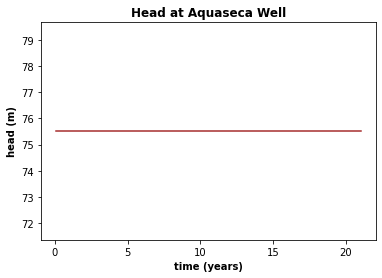

In [201]:
# Aquaseca well

cell_id1 = well_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at Aquaseca Well",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-', color="brown") #plot the time series with points at each record

plt.savefig("Head_Aqua"+str(name)+".png", dpi=600)
plt.show()


<ipython-input-202-2eb3352d115c>:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-', color="magenta") #plot the time series with points at each record


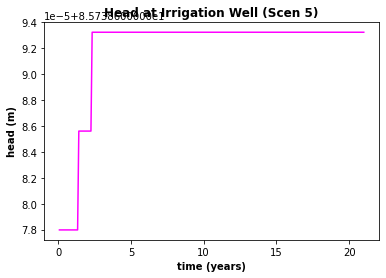

In [202]:
# Irrigation well
cell_id1 = welli_loc #cell at the center of the ag area
time_series1 = headobj.get_ts(cell_id1) #get the time series using flopy

#create firt plot  
plt.subplot(1, 1, 1)
plt.title("Head at Irrigation Well (Scen 5)",fontweight='bold')
plt.xlabel('time (years)',fontweight='bold')
plt.ylabel('head (m)',fontweight='bold')
#plt.ylim(89, 92)
plt.plot(time_series1[:, 0]/360, time_series1[:, 1], 'b-', color="magenta") #plot the time series with points at each record

plt.savefig("Head_irri"+str(name)+".png", dpi=600)
plt.show()